In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 128#1*1024

# gpus = tf.config.list_physical_devices('GPU')
# try:
#     tf.config.set_logical_device_configuration(gpus[0],
#                                               [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
# except RuntimeError as e:        
#     # Memory growth must be set before GPUs have been initialized
#     print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
# from turing.tf_utils import *
# import turing.pinns as tu
# from turing.loss_functions import *


from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from pde_solvers.cn import *

In [2]:
from local_utils import *
from turing.three_nodes_circuits import create_circuit_3954

# Load parameters

In [3]:
import pandas as pd
df = pd.read_csv("df_network_analysis_full_topology_with_estimates.csv")
df["index"] = range(df.shape[0])

In [4]:
def load_dataset(path, cont=False):
    if cont:
        with open(f"../{path[:-4]}_2", "rb") as f:
            k_max, params, res = np.load(f, allow_pickle=True)
    else:
        with open(f"../{path}", "rb") as f:
            k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return (params, res, k_max)

In [5]:
def act(x, K, n):
    """Activatrion"""
    return 1 / (1 + (K / (x + 1e-30)) ** n)


def inh(x, K, n):
    """Inhibition"""
    return 1 / (1 + (x / (K + 1e-30)) ** n)

A_act_AA = lambda A, K_AA: act(A, K_AA, 4)
A_inh_BA = lambda B, K_BA: inh(B, K_BA, 4)
A_prod = lambda A, K_AA, B, K_BA: A_act_BA(A, K_AA)*A_act_BA(B, K_BA)

B_act_AB = lambda A, K_AB: act(A, K_AB, 4)
B_inh_CB = lambda C, K_CB: inh(C, K_CB, 4)
B_prod = lambda A, K_AB, C, K_CB: B_act_AB(A, K_AB)*B_inh_CB(C, K_CB)

C_inh_AC = lambda A, K_AC: inh(A, K_AC, 4)
C_inh_BC = lambda B, K_BC: inh(B, K_BC, 4)
C_act_CC = lambda C, K_CC: act(C, K_CC, 4)
C_prod = lambda A, K_AC, B, K_BC, C, K_CC: C_inh_AC(A, K_AC)*C_inh_BC(B, K_BC)*C_act_CC(C, K_CC)

In [6]:
def to(arr):
    return arr.reshape(128, 128) 

In [7]:
np.set_printoptions(suppress=True)

In [8]:
from scipy import ndimage

def grad_2D(arr):
    kx =np.array([[1, 0, -1],
                  [2, 0, -2],
                  [1, 0, -1]])
    ky =np.array([[1, 2, 1],
                  [0, 0, 0],
                  [-1, -2, -1]])
    dx = ndimage.convolve(arr, kx)
    dy = ndimage.convolve(arr, ky)
    return np.hypot(dx, dy)


def diffu_2D(arr):
    kx =np.array([[1, 0, -1],
                  [2, 0, -2],
                  [1, 0, -1]])
    ky =np.array([[1, 2, 1],
                  [0, 0, 0],
                  [-1, -2, -1]])
    dx = ndimage.convolve(arr, kx)
    dy = ndimage.convolve(arr, ky)
    d2x = ndimage.convolve(dx, kx)
    d2y = ndimage.convolve(dy, ky)
    return d2x + d2y

def mid_points_2D(arr):
    kernel =np.array([[0, 1, 0],
                      [1, 0, 1],
                      [0, 1, 0]])/4
    return ndimage.convolve(arr, kernel)

In [9]:
def get_df_param(index):
    (n_val,
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = df.iloc[index]["params"]
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return params

In [10]:
df[df["bad_estimates"] == 5][df.columns[-20:-10]]

,b_C,V_C,K_AC,K_BC,K_CC,b_C_est,V_C_est,K_AC_est,K_BC_est,K_CC_est
36,20.0,100.0,1.0,1.0,1.0,12.094169,21.561844,57.254212,31.737980,0.458575
84,10.0,50.0,25.0,25.0,25.0,8.231034,250.026996,53.635921,72.290681,33.699846


In [11]:
from scipy.optimize import minimize

def rosenbrock(x1, x2, a=1, b=100):
    return (a-x1)**2 + b*(x2 - x1**2)**2

def alienor_components(epsilon, l1, bounds, ):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b, 1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i-1]
        # (pi/alpha)^(i-1) (b_i - a_i)
        alphas[i] = np.pi*alphas[i-1]*(b-a)/alpha
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2
        a,b = bounds[i]
        h_i = get_h_i(a,b, alphas[i])
        h_list.append(h_i)
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(d[1]-d[0])**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    theta_max = np.pi/alphas[0]
    return alpha, alphas, l2, h_list, theta_max

def minim(epsilon, l1, bounds, func, maxiter=10,method="Nelder-Mead"):
    alpha, alphas, l2, h_list, theta_max = alienor_components(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    
    theta = theta_max/2#np.pi/(2*alphas[0])  
    bounds=[(0, theta_max)]
    
    theta_epsilon = theta
    f = lambda t: func(*[ h(t) for h in h_list])
    
    f_epsilon = f(theta_epsilon)
    F_epsilon = f_epsilon - L*theta_max/2
    def single_F_k(f_theta, theta):
        def F_k(t):
            return f_theta - L*np.abs(theta - t)
        return F_k
    
    def get_F_k_func(F_k_list):
        def F_k_func(t):
            return np.max([f_i(t) for f_i in F_k_list])
        return F_k_func
    
    def get_F_k_func_vec(f_epsilon_arr, theta_arr):
        def F_k_func(t):
            return np.max(f_epsilon_arr - L*np.abs(theta_arr - t))
        return F_k_func
            
    theta_arr = np.array([theta])
    f_epsilon_arr = np.array([f_epsilon]) 
    F_k_func = get_F_k_func_vec(f_epsilon_arr, theta_arr)
    res = minimize(F_k_func, x0=0,hess=lambda x: np.zeros((x.shape[0], x.shape[0])),
                   bounds=bounds,  method=method)    
    theta = res['x'][0]        
    f_theta  =  f(theta)
    while k < maxiter:
        if f_epsilon - F_epsilon <= epsilon/2:            
            return (k, theta_arr, f_epsilon_arr, F_epsilon, F_k_func, 
                    theta_epsilon, f_epsilon, "")
        
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        
        theta_arr = np.concatenate([theta_arr, [theta]])
        f_epsilon_arr = np.concatenate([f_epsilon_arr, [f_epsilon]]) 
        F_k_func = get_F_k_func_vec(f_epsilon_arr, theta_arr)
        res = minimize(F_k_func, x0=0,hess=lambda x: np.zeros((x.shape[0], x.shape[0])),
                       bounds=bounds,  method=method)
        
        theta = res['x'][0] 
        f_theta  =  f(theta)
        F_epsilon = res['fun']
        k += 1    
    return (k, theta_arr, f_epsilon_arr, F_epsilon, F_k_func, 
                    theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached")

def alienor_components2(epsilon, l1, bounds):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b,1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i]
        # alphas[i-1] (alpha/pi) / (|b_i| + |a_i|)
        alphas[i] = alpha*alphas[i-1]/(np.pi*(np.abs(b)+np.abs(a)))
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2         
        h_i = h_i = get_h_i(a,b,alphas[i])#
        h_list.append(h_i)        
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(np.abs(d[1])+np.abs(d[0]))**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    #
    theta_max = np.pi/alphas[-1]    
    return alpha, alphas, l2, h_list, theta_max

def minim_2(epsilon, l1, bounds, func, maxiter=10000):
    alpha, alphas, l2, h_list, theta_max = alienor_components2(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    theta = epsilon / L    
    theta_epsilon = theta
    
    f = lambda t: func(*[ h(t) for h in h_list])
    f_epsilon = f_theta = f(theta_epsilon)
    
    while k < maxiter:
        if theta > np.pi/alphas[-1]:            
            return k, theta,theta_epsilon, f_epsilon, ""
        
        theta = theta + (epsilon + f_theta - f_epsilon)/ L        
        f_theta  =  f(theta)
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        k += 1    
    return k, theta,theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached"

In [12]:
D_A_val, D_B_val = 0.01, 1.0
N=5000
T=100
delta_t = T/N
model_128_10 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], delta_t=delta_t, Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D)

In [13]:
df["type"].unique()

array(['labyrinth', 'in-between', 'spot'], dtype=object)

In [14]:
df["index"].values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85])

0 outputs_second_search/solution_10_0_24.npy 2
original f_a loss: [38154099.3731719]
original f_b loss: [1128.17925362]
original f_c loss: [0.00000009]
delta theta A: 2e-05
delta theta A: 50000.0

delta theta B: 2e-05
delta theta B: 50000.0

delta theta C: 2.222222222222222e-06
delta theta C: 450000.0
A epochs: 5.0
B epochs: 5.0
C epochs: 45.0
0 final loss:291.67776136, params:0.54843999,4.38121915,7.98852857,7.45511211,13.59332524,15.65753560,25.64629562

0 init loss:2204968.52279536, params:0.14296206,0.55500027,0.00152684,1.05336437,0.21480031,15.77553023,25.59042810
1 final loss:294.46707130, params:0.69259997,4.43013603,6.39640544,9.88553480,14.27312005,12.69215096,12.16382775

1 init loss:724785.40490657, params:0.94906803,7.36377422,7.40362595,12.98866358,13.08225623,12.69565121,12.16006750
2 final loss:313.93744202, params:0.56784011,4.49924316,7.92341803,4.90686882,8.64127010,29.96683434,4.38557253

2 init loss:801742.39199187, params:8.16407862,5.86847870,0.67966580,6.9622600

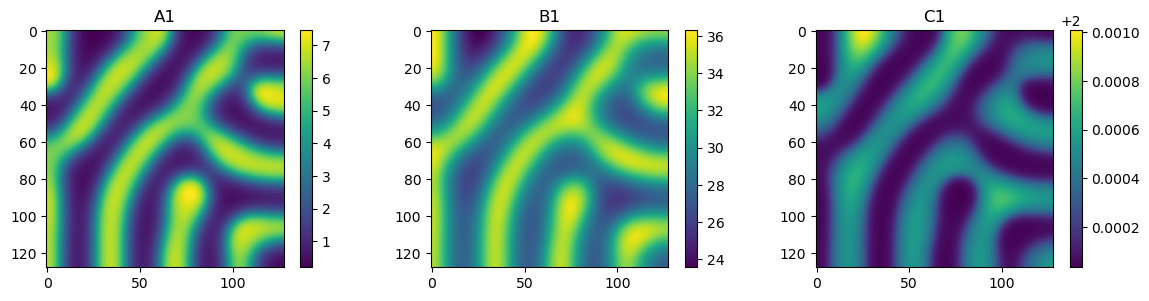

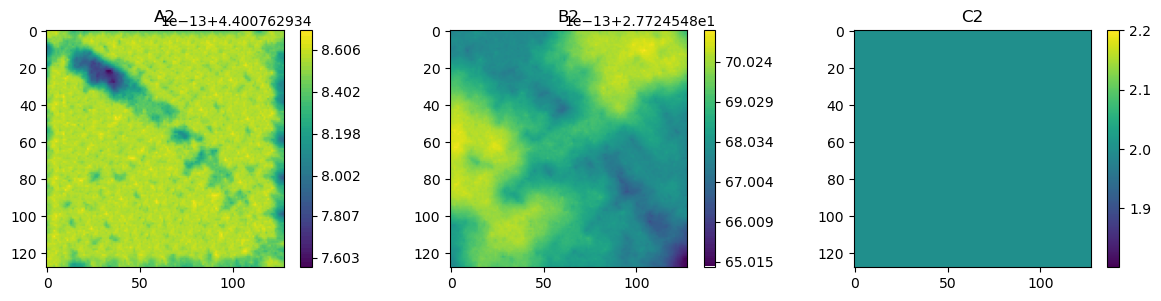

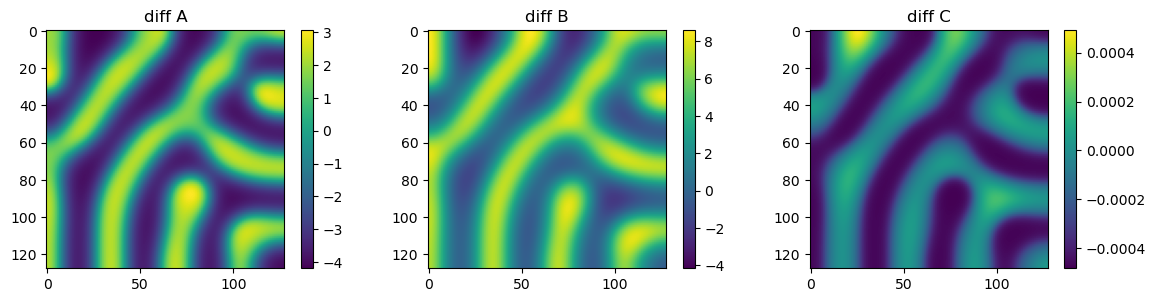

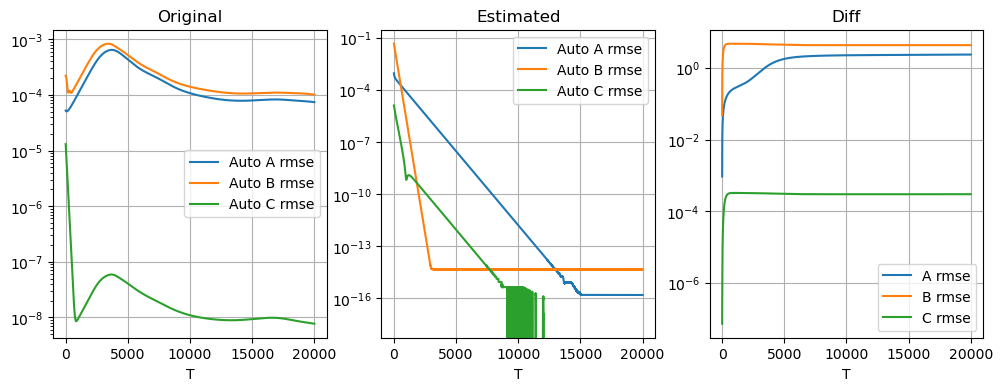

In [15]:
from multiprocessing import Pool, shared_memory
run_results = []
for run_index in [0]:#df["index"].values:


    path = df[df["index"] == run_index]["path"][run_index]
    #print(path)
    print(run_index, path, df["bad_estimates"].iloc[run_index])
    (params, res, k_max) = load_dataset(path)
    A = mid_points_2D(to(res[-1, 0, :]))
    B = mid_points_2D(to(res[-1, 1, :]))
    C = mid_points_2D(to(res[-1, 2, :]))
    


    def Create_f_A(A, B, C, n, mu_A):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A[2:-2, 2:-2].flatten()[np.newaxis, :]
        B_flat = B[2:-2, 2:-2].flatten()[np.newaxis, :]    
        #A_diffu =  0.01* diffu_2D(A).flatten()[np.newaxis, :]
        dxdy = (10*10)/(127*127)
        A_diffu = ((1.0/dxdy)*(diffusion((128, 128),A))[2:-2, 2:-2]).flatten()[np.newaxis, :]

        def L_2_f_a(args):
            (D_A, b_A_1, b_A_2, V_A_1, V_A_2, K_AA, K_BA
            ) = (args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4], args[:, 4:5],
                 args[:, 5:6], args[:, 6:7])
            f1 = (b_A_1 + V_A_1*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - A_flat 
                  + D_A*A_diffu)
            f2 = (b_A_2 + V_A_2*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - A_flat/D_A 
                  + A_diffu)
            f3 = (b_A_1 - b_A_2*D_A)**2 + (V_A_1 - V_A_2*D_A)**2 + (b_A_1*V_A_2 - b_A_2*V_A_1)**2
            f4 = 1/np.abs(b_A_1+1e-20) + 1/np.abs(b_A_2+1e-20)+1/np.abs(V_A_1+1e-20)+1/np.abs(V_A_1+1e-20)
            return np.sum((f1**2 + f2**2 )/A_flat.size+ 100*f3 + 1e-2*f4, axis=1)
        return L_2_f_a

    def Create_f_A_1_D(A, B, C, n, mu_A):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A[2:-2, 2:-2].flatten()[np.newaxis, :]
        B_flat = B[2:-2, 2:-2].flatten()[np.newaxis, :]    
        #A_diffu =  0.01* diffu_2D(A).flatten()[np.newaxis, :]
        dxdy = (10*10)/(127*127)
        A_diffu = ((1.0/dxdy)*(diffusion((128, 128),A))[2:-2, 2:-2]).flatten()[np.newaxis, :]
        def L_2_f_a(args):        
            (D_A, b_A_1, b_A_2, V_A_1, V_A_2, K_AA, K_BA
            ) = (args[0], args[1], args[2], args[3], args[4], args[5], args[6])
            f1 = (b_A_1 + V_A_1*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - A_flat 
                  + D_A*A_diffu)
            f2 = (b_A_2 + V_A_2*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - A_flat/D_A 
                  + A_diffu)
            f3 = (b_A_1 - b_A_2*D_A)**2 + (V_A_1 - V_A_2*D_A)**2 + (b_A_1*V_A_2 - b_A_2*V_A_1)**2
            f4 = 1/np.abs(b_A_1+1e-20) + 1/np.abs(b_A_2+1e-20)+1/np.abs(V_A_1+1e-20)+1/np.abs(V_A_1+1e-20)
            return np.sum((f1**2 + f2**2 )/A_flat.size+ 100*f3 + 1e-2*f4, axis=1)
        return L_2_f_a

    def Create_f_B(A, B, C, n, mu_B):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A[2:-2, 2:-2].flatten()[np.newaxis, :]
        B_flat = B[2:-2, 2:-2].flatten()[np.newaxis, :]   
        C_flat = C[2:-2, 2:-2].flatten()[np.newaxis, :]
        #B_diffu =  1.0* diffu_2D(B).flatten()[np.newaxis, :]
        dxdy = (10*10)/(127*127)
        B_diffu = ((1.0/dxdy)*(diffusion((128, 128),B))[2:-2, 2:-2]).flatten()[np.newaxis, :]
        def L_2_f_b(args):
            (D_B, b_B_1, b_B_2, V_B_1, V_B_2, K_AB, K_CB
            ) = (args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4], args[:, 4:5],
                 args[:, 5:6], args[:, 6:7])
            f1 = (b_B_1 + V_B_1*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - B_flat 
                 + D_B*B_diffu)
            f2 = (b_B_2 + V_B_2*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - B_flat/D_B 
                 + B_diffu)
            f3 = (b_B_1 - b_B_2*D_B)**2 + (V_B_1 - V_B_2*D_B)**2 + (b_B_1*V_B_2 - b_B_2*V_B_1)**2
            f4 = 1/np.abs(b_B_1+1e-20) + 1/np.abs(b_B_2+1e-20)+1/np.abs(V_B_1+1e-20)+1/np.abs(V_B_1+1e-20)
            return np.sum((f1**2 + f2**2 )/A_flat.size+ 100*f3 + 1e-2*f4, axis=1)
        return L_2_f_b

    def Create_f_B_1_D(A, B, C, n, mu_B):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A[2:-2, 2:-2].flatten()[np.newaxis, :]
        B_flat = B[2:-2, 2:-2].flatten()[np.newaxis, :]   
        C_flat = C[2:-2, 2:-2].flatten()[np.newaxis, :]
        #B_diffu =  1.0* diffu_2D(B).flatten()
        dxdy = (10*10)/(127*127)
        B_diffu = ((1.0/dxdy)*(diffusion((128, 128),B))[2:-2, 2:-2]).flatten()[np.newaxis, :]
        def L_2_f_b(args):        
            (D_B, b_B_1, b_B_2, V_B_1, V_B_2, K_AB, K_CB
            )  = (args[0], args[1], args[2], args[3], args[4], args[5], args[6])
            f1 = (b_B_1 + V_B_1*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - B_flat 
                 + D_B*B_diffu)
            f2 = (b_B_2 + V_B_2*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - B_flat/D_B 
                 + B_diffu)
            f3 = (b_B_1 - b_B_2*D_B)**2 + (V_B_1 - V_B_2*D_B)**2 + (b_B_1*V_B_2 - b_B_2*V_B_1)**2
            f4 = 1/np.abs(b_B_1+1e-20) + 1/np.abs(b_B_2+1e-20)+1/np.abs(V_B_1+1e-20)+1/np.abs(V_B_1+1e-20)
            return np.sum((f1**2 + f2**2 )/A_flat.size+ 100*f3 + 1e-2*f4, axis=1)
        return L_2_f_b

    def Create_f_C(A, B, C, n, mu_C):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A[2:-2, 2:-2].flatten()[np.newaxis, :]
        B_flat = B[2:-2, 2:-2].flatten()[np.newaxis, :]   
        C_flat = C[2:-2, 2:-2].flatten()[np.newaxis, :]
        def L_2_f_c(args):
            b_C, V_C, K_AC, K_BC, K_CC = args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4], args[:, 4:5]
            #b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
            f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
            return np.sum(f**2, axis=1)
        return L_2_f_c

    def Create_f_C_1_D(A, B, C, n, mu_C):
        def act(x, km, n=4):
            return 1 / (1 + (km / (x + 1e-20)) ** (n))

        def inh(x, km, n=4):
            return 1 / (1 + (x / (km + 1e-20)) ** (n))
        A_flat = A[2:-2, 2:-2].flatten()[np.newaxis, :]
        B_flat = B[2:-2, 2:-2].flatten()[np.newaxis, :]   
        C_flat = C[2:-2, 2:-2].flatten()[np.newaxis, :]
        def L_2_f_c(args):        
            b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
            f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
            return np.sum(f**2)
        return L_2_f_c


    f_a_loss = Create_f_A(A, B, C, 4, params["mu_A"])
    f_a_loss_1_D = Create_f_A_1_D(A, B, C, 4, params["mu_A"])
    f_b_loss = Create_f_B(A, B, C, 4, params["mu_B"])
    f_b_loss_1_D = Create_f_B_1_D(A, B, C, 4, params["mu_B"])
    f_c_loss = Create_f_C(A, B, C, 4, params["mu_C"])
    f_c_loss_1_D = Create_f_C_1_D(A, B, C, 4, params["mu_C"])

    print("original f_a loss:", 
          f_a_loss(
              np.array([[params["D_A"], params["b_A"], params["b_A"], params["V_A"], params["V_A"],
                         params["K_AA"], params["K_BA"]]]))
         )
    print("original f_b loss:", 
          f_b_loss(
              np.array([[params["D_B"], params["b_B"], params["b_B"], params["V_B"], params["V_B"],
                         params["K_AB"], params["K_CB"]]]))
         )
    print("original f_c loss:", 
          f_c_loss(
              np.array([[params["b_C"], params["V_C"], params["K_AC"], params["K_BC"], params["K_CC"]]]))
         )
    
    bounds_A = [(0,10), (0,30), (0,30), (0,200), (0,200), (0,30), (0,30)]
    bounds_B = [(0,10), (0,30), (0,30), (0,200), (0,200), (0,30), (0,30)]
    bounds_C = [(0,30), (0,200), (0,30), (0,30), (0,30)]
    epsilon = 1e-3
    l1 = 1

    alpha_A, alphas_A, l2_A, h_list2_A, theta_max2_A = alienor_components2(epsilon, l1, bounds_A)
    alpha_B, alphas_B, l2_B, h_list2_B, theta_max2_B = alienor_components2(epsilon, l1, bounds_B)
    alpha_C, alphas_C, l2_C, h_list2_C, theta_max2_C = alienor_components2(epsilon, l1, bounds_C)
    L_A = l1*l2_A
    L_B = l1*l2_B
    L_C = l1*l2_C
    print("delta theta A:", epsilon/L_A)
    print("delta theta A:", L_A/epsilon)
    print()
    print("delta theta B:", epsilon/L_B)
    print("delta theta B:", L_B/epsilon)
    print()
    print("delta theta C:", epsilon/L_C)
    print("delta theta C:", L_C/epsilon)
    
    batch_size = 10000
    print("A epochs:", L_A/epsilon/batch_size)
    print("B epochs:", L_B/epsilon/batch_size)
    print("C epochs:", L_C/epsilon/batch_size)

    thetas_A = np.linspace(0, theta_max2_A,  int(L_A/epsilon))
    thetas_B = np.linspace(0, theta_max2_B,  int(L_B/epsilon))
    thetas_C = np.linspace(0, theta_max2_C,  int(L_C/epsilon))

    params_by_theta_A = np.stack([h_list2_A[0](thetas_A), h_list2_A[1](thetas_A),
                                  h_list2_A[2](thetas_A), h_list2_A[3](thetas_A),
                                  h_list2_A[4](thetas_A), h_list2_A[5](thetas_A),
                                  h_list2_A[6](thetas_A)]).T

    params_by_theta_B = np.stack([h_list2_B[0](thetas_B), h_list2_B[1](thetas_B),
                                  h_list2_B[2](thetas_B), h_list2_B[3](thetas_B),
                                  h_list2_B[4](thetas_B), h_list2_B[5](thetas_B),
                                  h_list2_B[6](thetas_B)]).T

    params_by_theta_C = np.stack([h_list2_C[0](thetas_C), h_list2_C[1](thetas_C),
                                  h_list2_C[2](thetas_C), h_list2_C[3](thetas_C),
                                  h_list2_C[4](thetas_C)]).T

    theta_A_n = params_by_theta_A.shape[0]
    theta_A_m = params_by_theta_A.shape[1]
    theta_B_n = params_by_theta_B.shape[0]
    theta_B_m = params_by_theta_B.shape[1]
    theta_C_n = params_by_theta_C.shape[0]
    theta_C_m = params_by_theta_C.shape[1]
    
    def singA(args):
        batch_id,theta_n,theta_m= args 
        params_shm = shared_memory.SharedMemory(name="params_by_theta")
        output_shm = shared_memory.SharedMemory(name="outputs")
        thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
        f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
        f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_a_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
        return batch_id

    def singB(args):
        batch_id,theta_n,theta_m= args 
        params_shm = shared_memory.SharedMemory(name="params_by_theta")
        output_shm = shared_memory.SharedMemory(name="outputs")
        thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
        f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
        f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_b_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
        return batch_id

    def singC(args):
        batch_id,theta_n,theta_m= args 
        params_shm = shared_memory.SharedMemory(name="params_by_theta")
        output_shm = shared_memory.SharedMemory(name="outputs")
        thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
        f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
        f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_c_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
        return batch_id

    def run(theta_n,theta_m,params_by_theta, sing, L, epsilon, batch_size):
        shm = shared_memory.SharedMemory(name="params_by_theta",create=True, size=params_by_theta.nbytes)
        shared_thetas = np.ndarray((theta_n,theta_m), dtype=np.float64,
                                    buffer=shm.buf)

        shared_thetas[:,:] = params_by_theta[:,:]


        f_thetas = np.zeros(theta_n)
        shm_out = shared_memory.SharedMemory(name="outputs",create=True, size=f_thetas.nbytes)
        shared_outputs = np.ndarray((theta_n), dtype=np.float64,
                                     buffer=shm_out.buf)


        args =[ (batch_id, theta_n,theta_m) for batch_id in range(int(L/epsilon/batch_size) + 1)]

        with Pool(55) as pool:
            res = pool.map(sing, args)

        f_thetas[:] = shared_outputs[:]
        shm.close()
        shm.unlink()

        shm_out.close()
        shm_out.unlink()

        return f_thetas
    
    
    
    
    f_thetas_A = run(theta_A_n,theta_A_m,params_by_theta_A, singA, L_A, epsilon, batch_size)
    f_thetas_B = run(theta_B_n,theta_B_m,params_by_theta_B, singB, L_B, epsilon, batch_size)
    f_thetas_C = run(theta_C_n,theta_C_m,params_by_theta_C, singC, L_C, epsilon, batch_size)
    
    def minimise_top_n(n, h_list, bounds, loss_1_D, f_thetas, thetas):
        shift = 0
        init_params = np.zeros((n, len(h_list)))
        final_params = np.zeros((n, len(h_list)))
        init_loss = np.zeros(n)
        final_loss = np.zeros(n)

        top_n = np.argpartition(-f_thetas, -n)[-n:]
        top_n = top_n[np.argsort(f_thetas[top_n])]

        for shift in range(n):

            theta_star = thetas[top_n][0 + shift]
            init_par = tuple([h(theta_star) for h in h_list])
            init_params[shift, :] = init_par
            init_loss[shift] = f_thetas[top_n][0 + shift]
            #bounds = ((0, 200), (0, 200), (0, 200), (0, 200), (0, 200))
            res3= minimize(loss_1_D, x0=init_par, method='L-BFGS-B', bounds=bounds)#, options={'ftol':1e-10})
            final_params[shift, :] = res3['x']
            final_loss[shift] = res3['fun']

        sorted_loss_ind = np.argsort(final_loss)
        init_params = init_params[sorted_loss_ind.tolist()]
        init_loss = init_loss[sorted_loss_ind.tolist()]
        final_params = final_params[sorted_loss_ind.tolist()]
        final_loss = final_loss[sorted_loss_ind.tolist()]

        return (final_loss, final_params, init_loss, init_params )
    
    (final_loss_A, final_params_A, 
     init_loss_A, init_params_A) = minimise_top_n(10, h_list2_A, 
                                                  ((0, 20), (0, 500), (0, 500), (0, 500), (0, 500), (0, 500), (0, 500)), 
                                                  f_a_loss_1_D, f_thetas_A, thetas_A)
    
    (final_loss_B, final_params_B, 
     init_loss_B, init_params_B) = minimise_top_n(10, h_list2_B, 
                                                  ((0, 20), (0, 500), (0, 500), (0, 500), (0, 500), (0, 500), (0, 500)), 
                                                  f_b_loss_1_D, f_thetas_B, thetas_B)
    
    (final_loss_C, final_params_C, 
     init_loss_C, init_params_C) = minimise_top_n(10, h_list2_C, 
                                                  ((0, 500), (0, 500), (0, 500), (0, 500), (0, 500)), 
                                                  f_c_loss_1_D, f_thetas_C, thetas_C)
    
    for i, (a,b,c,d) in enumerate(zip(final_loss_A, final_params_A,init_loss_A, init_params_A)):
        print(i, f"final loss:{a:.8f}, params:{','.join([f'{value:.8f}' for value in b])}")
        print()
        print(i, f"init loss:{c:.8f}, params:{','.join([f'{value:.8f}' for value in d])}")
        print("="*40)
        
    for i, (a,b,c,d) in enumerate(zip(final_loss_B, final_params_B,init_loss_B, init_params_B)):
        print(i, f"final loss:{a:.8f}, params:{','.join([f'{value:.8f}' for value in b])}")
        print()
        print(i, f"init loss:{c:.8f}, params:{','.join([f'{value:.8f}' for value in d])}")
        print("="*40)
        
    for i, (a,b,c,d) in enumerate(zip(final_loss_C, final_params_C,init_loss_C, init_params_C)):
        print(i, f"final loss:{a:.8f}, params:{','.join([f'{value:.8f}' for value in b])}")
        print()
        print(i, f"init loss:{c:.8f}, params:{','.join([f'{value:.8f}' for value in d])}")
        print("="*40)
        
    print(df["path"].iloc[run_index])
    (params, res, k_max) = load_dataset(df["path"].iloc[run_index])



    (_,_,n_val, 
             b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
             b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
             b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params.values()

    kinetics = create_circuit_3954(n_val, 
                                   b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                                   b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                                   b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  

    A = res[0, 0, :]
    B = res[0, 1, :]
    C = res[0, 2, :]      
    res_1 = model_128_10.integrate([A,B,C], kinetics, 4*5000, 1)    
    print(f"D_A:0.01, D_B:1.0, b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
          f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
          f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
          f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
          f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
          f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")
    
    def simulate_by(index, 
                final_params_A=final_params_A, 
                final_params_B=final_params_B, 
                final_params_C=final_params_C):
        D_A_1_val, b_A_1_val, b_A_2_val, V_A_1_val, V_A_2_val,  K_AA_val,  K_BA_val = final_params_A[index]
        D_B_1_val, b_B_1_val, b_B_2_val, V_B_1_val, V_B_2_val,  K_AB_val,  K_CB_val = final_params_B[index]
        b_C_val, V_C_val,  K_AC_val,  K_BC_val, K_CC_val = final_params_C[index]

#         print(b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
#                                        b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
#                                        b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
        print()
        print(f"D_A_1:{D_A_1_val:.4f}, b_A_1:{b_A_1_val:.4f}, b_A_2:{b_A_2_val:.4f}, "
              f"V_A_1:{V_A_1_val:.4f}, V_A_2:{V_A_2_val:.4f}")
        print(f"b_A_1-b_A_2*D_A_1:{b_A_1_val - b_A_2_val*D_A_1_val:.8f}")
        print(f"V_A_1-V_A_2*D_A_1:{V_A_1_val - V_A_2_val*D_A_1_val:.8f}")
        print(f"b_A_1*V_A_2-b_A_2*V_A_1:{b_A_1_val*V_A_2_val - b_A_2_val*V_A_1_val:.8f}")
        print()
        print(f"D_B_1:{D_B_1_val:.4f}, b_B_1:{b_B_1_val:.4f}, b_B_2:{b_B_2_val:.4f}, "
              f"V_B_1:{V_B_1_val:.4f}, V_B_2:{V_B_2_val:.4f}")
        print(f"b_B_1-b_B_2*D_B_1:{b_B_1_val - b_B_2_val*D_B_1_val:.8f}")
        print(f"V_B_1-V_B_2*D_B_1:{V_B_1_val - V_B_2_val*D_B_1_val:.8f}")
        print(f"b_B_1*V_B_2-b_B_2*V_B_1:{b_B_1_val*V_B_2_val - b_B_2_val*V_B_1_val:.8f}")
        D_A_val = D_A_1_val * mu_A_val
        D_B_val = D_B_1_val * mu_B_val
        b_A_val = b_A_1_val * mu_A_val
        b_B_val = b_B_1_val * mu_B_val
        V_A_val = V_A_1_val * mu_A_val
        V_B_val = V_B_1_val * mu_B_val        
        print()
        print(f"D_A:{D_A_val:.4f}, D_B:{D_B_val:.4f}, b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
              f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
              f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
              f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
              f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
              f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")
        kinetics = create_circuit_3954(n_val, 
                                       b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                                       b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                                       b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  

        N=5000
        T=100
        delta_t = T/N
        model_128_10_2 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], delta_t=delta_t, Lx=10, Ly=10, 
                                       Ix=128, Jy=128,
                                       boundary_condition=Neumann_Boundary_2D)
        res_2 = model_128_10_2.integrate([A,B,C], kinetics, 4*5000, 1)
        A1 = res_1[-1, 0, :]
        B1 = res_1[-1, 1, :]
        C1 = res_1[-1, 2, :]
        plot_n_im([to(A1), to(B1), to(C1)], 
                      ["A1", "B1", "C1"],          
                      figsize=(12, 3)); plt.tight_layout();plt.show()

        A2 = res_2[-1, 0, :]
        B2 = res_2[-1, 1, :]
        C2 = res_2[-1, 2, :] 
        plot_n_im([to(A2), to(B2), to(C2)], 
                      ["A2", "B2", "C2"],          
                      figsize=(12, 3)); plt.tight_layout();plt.show()

        plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
                      ["diff A", "diff B", "diff C"],          
                      figsize=(12, 3)); plt.tight_layout();plt.show()
        def RMSE(a1, a2):
            return np.sqrt(np.mean((a1-a2)**2, axis=1))
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
        plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
        plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
        plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

        plt.subplot(132)
        plt.plot(RMSE(res_2[1:, 0, :], res_2[:-1, 0, :]) , label="Auto A rmse")
        plt.plot(RMSE(res_2[1:, 1, :], res_2[:-1, 1, :]) , label="Auto B rmse")
        plt.plot(RMSE(res_2[1:, 2, :], res_2[:-1, 2, :]) , label="Auto C rmse")
        plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

        plt.subplot(133)
        plt.plot(RMSE(res_1[:, 0, :], res_2[:, 0, :]) , label="A rmse")
        plt.plot(RMSE(res_1[:, 1, :], res_2[:, 1, :]) , label="B rmse")
        plt.plot(RMSE(res_1[:, 2, :], res_2[:, 2, :]) , label="C rmse")
        plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
        plt.show()
        return res_2
    
    
    res_2 = simulate_by(0)
    
    
#     with open(f"./alienor_mesh_diffusion_simulations/simulation_original_{run_index}.npy", "wb") as f:
#         np.save(f, res_1[::500, :, :])
#     with open(f"./alienor_mesh_diffusion_simulations/simulation_estimate_{run_index}.npy", "wb") as f:
#         np.save(f, res_2[::500, :, :])
        
    del res_1
    del res_2
    run_results.append({
        'run_index':run_index,
        'final_loss_A':final_loss_A, 
        'final_params_A':final_params_A,
        'init_loss_A':init_loss_A, 
        'init_params_A':init_params_A,
        'final_loss_B':final_loss_B, 
        'final_params_B':final_params_B,
        'init_loss_B':init_loss_B, 
        'init_params_B':init_params_B,
        'final_loss_C':final_loss_C, 
        'final_params_C':final_params_C,
        'init_loss_C':init_loss_C, 
        'init_params_C':init_params_C        
    })

    

In [ ]:
params_shm = shared_memory.SharedMemory(name="params_by_theta")
output_shm = shared_memory.SharedMemory(name="outputs")

params_shm.close()
params_shm.unlink()

output_shm.close()
output_shm.unlink()